<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Agentic-AI-LLM-Apps/blob/main/Comprehensive-DL-Tensorflow(Maktabkhoone)/27_text_classification_persian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Imports*

In [11]:

import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

print(tf.__version__)

2.19.0


*Download Data*

In [26]:
url = "https://github.com/Alireza-Akhavan/text-classification/raw/main/6-persian-topics.zip"

dataset = tf.keras.utils.get_file("6-persian-topics.zip",
                                  url,
                                  extract=True,
                                  cache_dir=".",
                                  cache_subdir="")
dataset_dir = os.path.join(dataset, "6-persian-topics")


In [28]:
# Check topics
os.listdir(dataset_dir)

['دین و اعتقاد',
 'بهداشت و سلامت',
 'ورزش',
 'ریاضیات',
 'فناوری و علوم کاربردی و تکنولوژی',
 'جغرافیا و مکانها']

In [30]:
# Check sample data
sample_file = os.path.join(dataset_dir, 'ریاضیات/1000847.txt')
with open(sample_file) as f:
  print(f.read())

نظریه انشعاب یا نظریه دوشاخگی (به انگلیسی: Bifurcation theory) به مطالعه ریاضیِ تغییرات کیفی یا توپولوژیکی ساختار حوزه‌هایی مانند منحنی‌های انتگرالِ میدان برداری و حل معادله دیفرانسیل می‌پردازد. نظریه انشعاب در بررسیِ سیستم پویا کاربرد دارد. هنگامی که یک تغییر کوچکِ نرم، منجر به تغییر در رفتار سیستم شده و یک انشعاب ناگهانیِ کیفی یا تغییر از نظر توپولوژی اتفاق می‌افتد.


*Load Data*

In [46]:
BATCH_SIZE = 32
SEED = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    dataset_dir,
    batch_size=BATCH_SIZE,
    seed=SEED,
    validation_split=0.2,
    subset="training"
)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    dataset_dir,
    batch_size=BATCH_SIZE,
    seed=SEED,
    validation_split=0.2,
    subset="validation",
)


Found 37573 files belonging to 6 classes.
Using 30059 files for training.
Found 37573 files belonging to 6 classes.
Using 7514 files for validation.


In [33]:
# Get a sample batch
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(10):
        print(f"Text: {text_batch.numpy()[i].decode()}")
        print(f"Label: {label_batch.numpy()[i]}")

Text: آافیر (به لاتین: Aafir) در الجزایر با جمعیت ۱۲٬۶۱۳ نفر است که در استان بومرداس واقع شده‌است.
Label: 1
Text: نبردناو کلاس مونتانا (به انگلیسی: Montana-class battleship) یک کلاس از کشتی است که طول آن ۹۲۰ فوت ۶ اینچ (۲۸۰٫۵۷ متر) می‌باشد.
Label: 4
Text: کن فِم (به آلمانی: KenFM)، یک پایگاه خبری تحلیلی آلمانی است.
Label: 4
Text: شهرستان آدامز، کلرادو (به انگلیسی: Adams County, Colorado) یک سکونتگاه مسکونی در ایالات متحده آمریکا است که در کلرادو واقع شده‌است.
Label: 1
Text: موشان (به لاتین: Mosjøen) (تلفظ نروژی: [ˈmu:ʃøn] گوش‌دادن ) یک شهرک در نروژ است که در وفسن واقع شده‌است. موشان ۶٫۴۱ کیلومتر مربع مساحت و ۹٬۶۶۵ نفر جمعیت دارد.
Label: 1
Text: سیداد کولونیالاین مکان در سال ۱۹۹۰ در میراث جهانی یونسکو به ثبت رسید.
Label: 1
Text: ایران از ۱۸ اوت تا ۲ سپتامبر ۲۰۱۸ در بازی‌های آسیایی ۲۰۱۸ در جاکارتا و پالم‌بانگ اندونزی شرکت کرد. ایران از اولین دوره بازی‌ها در دهلی‌نو ۱۹۵۱ در بازی‌های آسیایی شرکت کرده‌است و بهترین دستاورد ایران در سال ۱۹۷۴ بود، زمانی که ایران میزبان این بازی‌ها بود. در تهرا

In [37]:
# Get labels
for i in range(6):
    print(f"Label {i}, coressponds to {raw_train_ds.class_names[i]}")

Label 0, coressponds to بهداشت و سلامت
Label 1, coressponds to جغرافیا و مکانها
Label 2, coressponds to دین و اعتقاد
Label 3, coressponds to ریاضیات
Label 4, coressponds to فناوری و علوم کاربردی و تکنولوژی
Label 5, coressponds to ورزش


*Prepare Dataset for Training*

Next, you will standardize, tokenize, and vectorize the data using the helpful tf.keras.layers.TextVectorization layer.

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like <br />. These tags will not be removed by the default standardizer in the TextVectorization layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

Note: To prevent training-testing skew (also known as training-serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the TextVectorization layer can be included directly inside your model, as shown later in this tutorial.

In [47]:
def custom_standardization(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    stripped_ye = tf.strings.regex_replace(stripped_html, 'ي', 'ی')
    return tf.strings.regex_replace(stripped_ye,
                                  '[%s]' % re.escape(string.punctuation), '')

In [39]:
# Test
txt = " براي برای"
print(txt)
print(custom_standardization(txt).numpy().decode())

 براي برای
 برای برای


In [48]:
# TextVectorization
VOCAB_SIZE = 10_000
SEQUENCE_LENGTH = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)

# Adapt data
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [49]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [50]:

# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review.numpy().decode())
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review اس-ادنوزیل متیونین (به انگلیسی: S-Adenosyl methionine) با فرمول شیمیایی C۱۵H۲۲N۶O۵S+ یک ترکیب شیمیایی با شناسه پاب‌کم ۹۸۶۵۶۰۴ است که جرم مولی آن ۳۹۸٫۴۴ g/mol می‌باشد. این مولکول یکی از کوآنزیم‌های واکنش‌های سلولی (به ویژه در باکتری‌ها) جهت انتقال گروه متیل می‌باشد.
Label بهداشت و سلامت
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   1,    1,    3,   12,    1,    1,   13,  542, 1985,    1,    9,
        1071, 1985,   13, 4470, 7415,    1,    5,    6, 2777, 6926,   15,
           1, 8639,   45,    8, 7483,   28,    7,    1, 4834, 3756,    3,
         803,    2, 4728,  551,  639,  252,    1,   45,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    

In [51]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  خودرویی
 313 --->  روستا
Vocabulary size: 10000


In [52]:
# Apply vectorize layer to data
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)

*Configure the Dataset for Performance*

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

.cache() keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

.prefetch() overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the data performance guide.

In [53]:

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


*Model Definition*

In [55]:
EMBEDDING_DIM = 16


model = tf.keras.Sequential([
  layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
  layers.GlobalAveragePooling1D(),
  layers.Dense(100),
  layers.Dropout(0.5),
  layers.Dense(6)])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [57]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [58]:

epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/15
940/940 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6027 - loss: 1.1231 - val_accuracy: 0.8756 - val_loss: 0.4302
Epoch 2/15
940/940 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8794 - loss: 0.3836 - val_accuracy: 0.9035 - val_loss: 0.2685
Epoch 3/15
940/940 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9256 - loss: 0.2437 - val_accuracy: 0.9425 - val_loss: 0.1867
Epoch 4/15
940/940 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9447 - loss: 0.1793 - val_accuracy: 0.9575 - val_loss: 0.1438
Epoch 5/15
940/940 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9543 - loss: 0.1441 - val_accuracy: 0.9622 - val_loss: 0.1273
Epoch 6/15
940/940 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9622 - loss: 0.1181 - val_accuracy: 0.9661 - val_loss: 0.1151
Epoch 7/15
940/940 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9675 - loss: 0.1012 - val_accuracy: 0.9665 - val_loss: 0.1116
Epoch 8/15
940/940 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9724 - loss: 0.0902 - val_accuracy: 

*Evaluate Model*

*Plots*

In [59]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

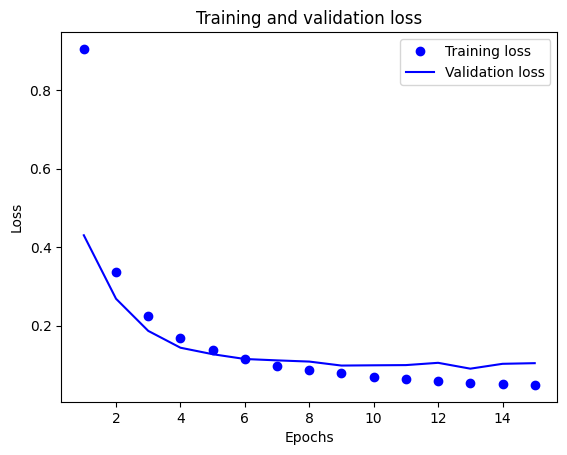

In [60]:

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

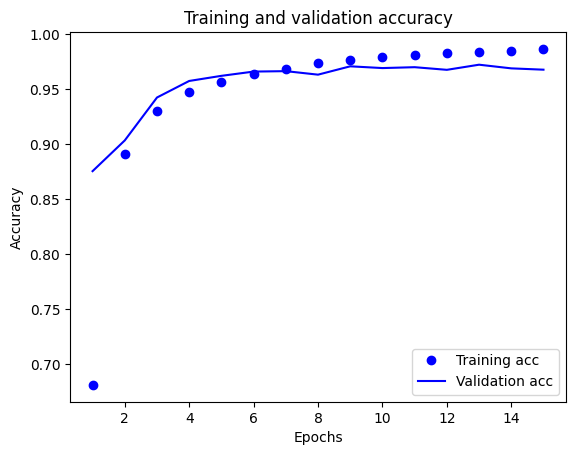

In [61]:

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

*Export Model*

In [63]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation("softmax")
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_val_ds)
print(accuracy)


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9674 - loss: 0.0973
0.9677934646606445


*Inference On New Data*

In [65]:
import numpy as np
import tensorflow as tf

examples = [
  "ویروس کرونا جان خیلی ها را گرفت",
  "فوتبال نوجوانان کشور با نتیجه 2 بر 0 به پایان رسید.",
  "تهران پایخت ایران است."
]

p = export_model.predict(tf.constant(examples))
results = np.argmax(p, axis=1)

for r in results:
  print(raw_train_ds.class_names[r])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
جغرافیا و مکانها
جغرافیا و مکانها
جغرافیا و مکانها


*Confusion Matrx*

In [66]:
features = raw_val_ds.map(lambda x, y: x)
labels = raw_val_ds.map(lambda x, y: y)

In [67]:
predictions = export_model.predict(features)
predicted_classes = tf.math.argmax(predictions, axis=-1)

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [68]:
# Get the actual data from the MapDataset object
labels_list = list(labels.as_numpy_iterator())

# Flatten the batched labels
labels = np.concatenate(labels_list, axis=0)

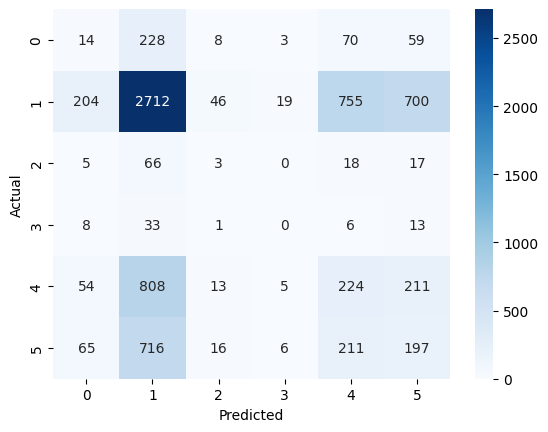

In [69]:
confusion_mtx = tf.math.confusion_matrix(labels, predicted_classes)


import seaborn as sns
import matplotlib.pyplot as plt


sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [70]:
!pip install -q python-bidi arabic_reshaper

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 3.8 MB/s eta 0:00:00


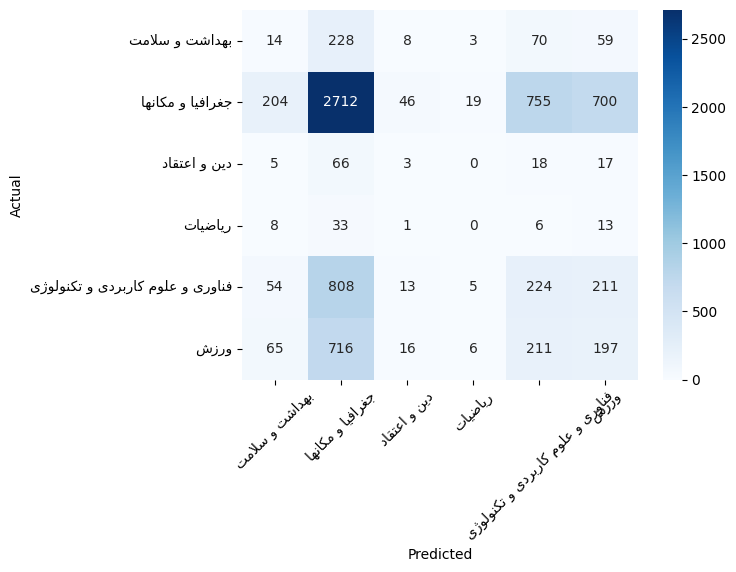

In [71]:
import arabic_reshaper
from bidi.algorithm import get_display

def convert_text(t):
    reshaped_text = arabic_reshaper.reshape(t) # seperated chars problem
    bidi_text = get_display(reshaped_text) #direction problem
    text = bidi_text.encode().decode('utf-8') #encoding problem (rectangular boxes!)
    return text

class_names = [convert_text(t) for t in raw_train_ds.class_names]

sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(np.arange(len(class_names))+0.5, class_names, rotation=45)
plt.yticks(np.arange(len(class_names))+0.5, class_names, rotation=0)

plt.show()


In [72]:

from sklearn.metrics import classification_report
report = classification_report(labels, predicted_classes)

for i in range(6):
  print("Label {} corresponds to {}".format(i, raw_train_ds.class_names[i]))
print(report)

Label 0 corresponds to بهداشت و سلامت
Label 1 corresponds to جغرافیا و مکانها
Label 2 corresponds to دین و اعتقاد
Label 3 corresponds to ریاضیات
Label 4 corresponds to فناوری و علوم کاربردی و تکنولوژی
Label 5 corresponds to ورزش
              precision    recall  f1-score   support

           0       0.04      0.04      0.04       382
           1       0.59      0.61      0.60      4436
           2       0.03      0.03      0.03       109
           3       0.00      0.00      0.00        61
           4       0.17      0.17      0.17      1315
           5       0.16      0.16      0.16      1211

    accuracy                           0.42      7514
   macro avg       0.17      0.17      0.17      7514
weighted avg       0.41      0.42      0.41      7514

